In [135]:
# preprocessing
import pandas as pd
import re
from nltk.corpus import stopwords

# method
from collections import Counter
from wordcloud import WordCloud
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models
from textblob import TextBlob

#visualization
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [136]:
tweets = pd.read_csv('tweets.csv')

In [137]:
# Convert 'time' column to datetime format
tweets["time"] = pd.to_datetime(tweets["time"], format="%Y-%m-%dT%H:%M:%S")

tweets["date"] = tweets["time"].dt.strftime("%Y-%m-%d")

In [138]:
# Define list of features to keep
FEATURES = ['date', 'text', 'retweet_count', 'favorite_count', 'handle']

# Select only the specified features from the 'tweets' DataFrame
tweets = tweets[FEATURES]

In [139]:
def preprocess_text(text):
    """
    Preprocesses the input text by removing punctuation, converting to lowercase,
    and removing stop words.
    
    Args:
    - text: A string containing each row of text data
    
    Returns:
    - preprocessed_no_stopwords: A list of preprocessed words with stop words removed
    """
    
    # Remove punctuation and convert to lowercase
    preprocessed_text = re.sub(r'[^\w\s]', '', text).lower()
    
    # Split the text into words
    preprocessed_words = preprocessed_text.split()

    # Remove stop words
    stop_words = set(stopwords.words('english'))

    preprocessed_no_stopwords = [word for word in preprocessed_words if word not in stop_words]
    
    return preprocessed_no_stopwords

tweets['preprocessed_text'] = tweets['text'].apply(preprocess_text)

### The LDAvis visualization arc

In [140]:
preprocessed_text_all = [item for sublist in tweets['preprocessed_text'] for item in sublist]

In [141]:
# Tokenize the text
tokenized_text = [text.split() for text in preprocessed_text_all]

# Create dictionary
dictionary = Dictionary(tokenized_text)

# Filter out tokens that appear in less than 5 documents or more than 50% of the documents
dictionary.filter_extremes(no_above=0.5)

# Convert text to bag-of-words format
corpus = [dictionary.doc2bow(text) for text in tokenized_text]

# Train LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10, 
    random_state=699,
#    update_every=1,
#    chunksize=100,
#    alpha='auto',
#    passes=15,
#    decay=0.5,
#    per_word_topics=True
)

In [142]:
# Generate Topic Distance Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

/Users/yonniechan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/yonniechan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/yonniechan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/yonniechan/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.062359  0.147938       1        1  10.685655
4     -0.426980 -0.035868       2        1  10.525287
9      0.058214  0.095796       3        1  10.432700
6      0.029611  0.022959       4        1  10.072720
0      0.094488 -0.404861       5        1   9.993706
5      0.057678  0.073217       6        1   9.954558
3      0.038012  0.033713       7        1   9.764051
2      0.030769  0.024273       8        1   9.617214
1      0.030162  0.023658       9        1   9.563589
7      0.025687  0.019174      10        1   9.390518, topic_info=                Term         Freq        Total Category  logprob  loglift
11             trump  1810.000000  1810.000000  Default  30.0000  30.0000
96             great  1405.000000  1405.000000  Default  29.0000  29.0000
102            thank  1437.000000  1437.000000  Default  28.0000  28.0000
343  realdonaldtrump  1354.000000  1354.000000  Default  27.0000  27.0000
278              new  1033.000000  1033.000000  Default  26.0000  26.0000
..               ...          ...          ...      ...      ...      ...
357            hands    28.833200    30.403339  Topic10  -5.1389   2.3124
410         complete    28.601319    30.171962  Topic10  -5.1470   2.3120
479            clean    26.845460    28.415598  Topic10  -5.2103   2.3086
339            hours    26.588883    28.159021  Topic10  -5.2199   2.3081
240            stage    26.435162    28.006229  Topic10  -5.2257   2.3077

[330 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
256       8  0.979841       1
155       6  0.963567      10
490       4  0.968778      15
64        8  0.954915       3
462       2  0.968759  advice
...     ...       ...     ...
289       5  0.992651     wow
242       3  0.971682     wsj
247       9  0.993311   years
35        9  0.958020   youre
442       9  0.985434    zero

[300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 5, 10, 7, 1, 6, 4, 3, 2, 8])

### Comparison of Trump and Clinton's word frequency

In [143]:
# Filter tweets data to separate those authored by Donald Trump and Hillary Clinton
trump = tweets[tweets['handle'] == 'realDonaldTrump']  # Select tweets from Donald Trump
clinton = tweets[tweets['handle'] == 'HillaryClinton']  # Select tweets from Hillary Clinton

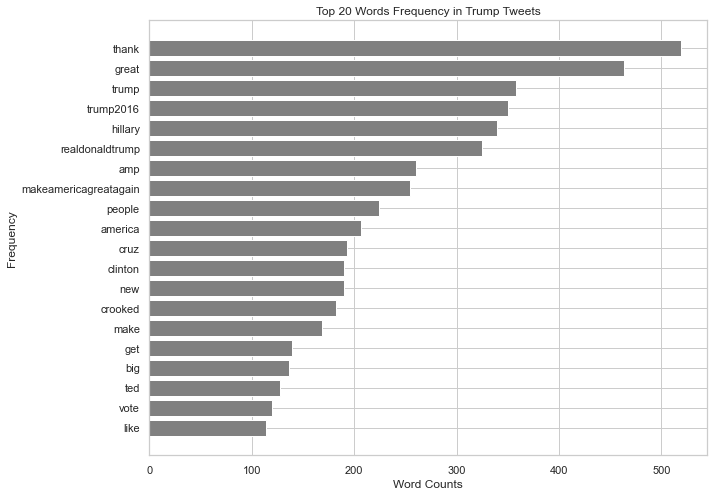

In [144]:
trump_all = [item for sublist in trump['preprocessed_text'] for item in sublist]
trump_freq20 = dict(Counter(trump_all).most_common(20))

# Extract data from trump_freq
words = list(trump_freq20.keys())
frequencies = list(trump_freq20.values())

# Plot horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(words, frequencies, color='grey')
plt.xlabel('Word Counts')
plt.ylabel('Frequency')
plt.title('Top 20 Words Frequency in Trump Tweets')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.show()

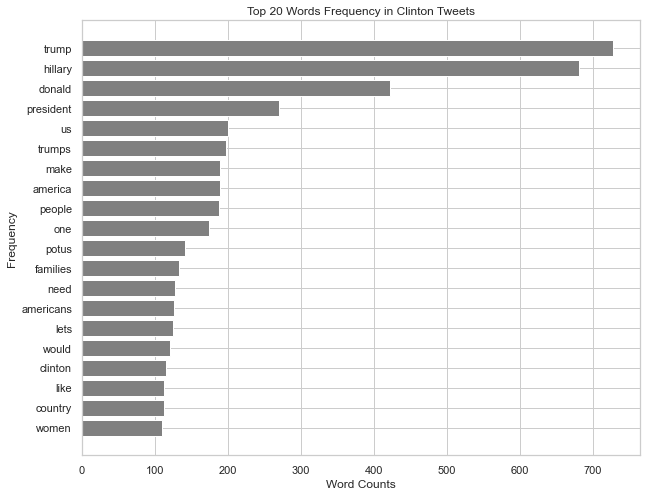

In [145]:
clinton_all = [item for sublist in clinton['preprocessed_text'] for item in sublist]
clinton_freq20 = dict(Counter(clinton_all).most_common(20))

# Extract data from clinton_freq
words = list(clinton_freq20.keys())
frequencies = list(clinton_freq20.values())

# Plot horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(words, frequencies, color='grey')
plt.xlabel('Word Counts')
plt.ylabel('Frequency')
plt.title('Top 20 Words Frequency in Clinton Tweets')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.show()

### Word cloud of Trump and Clinton’s word frequency

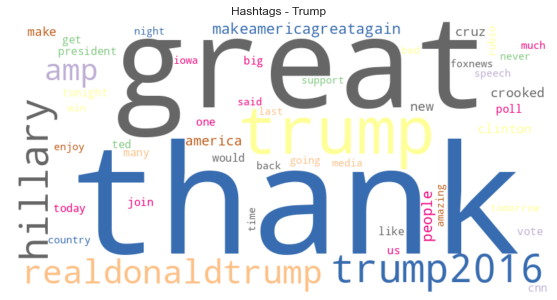

In [146]:
trump_freq50 = dict(Counter(trump_all).most_common(50))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="Accent_r", random_state = 699).generate_from_frequencies(trump_freq50)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Hashtags - Trump")
plt.show()

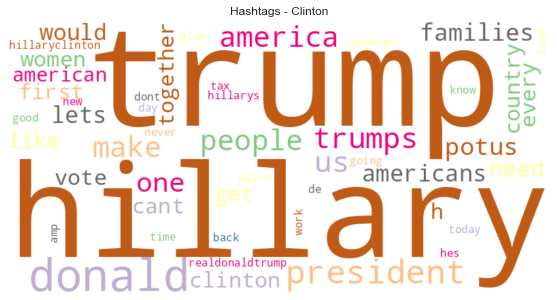

In [147]:
clinton_freq50 = dict(Counter(clinton_all).most_common(50))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="Accent_r", random_state = 699).generate_from_frequencies(clinton_freq50)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Hashtags - Clinton")
plt.show()

### Spread and skewness comparison of sentiment scores for Clinton and Trump

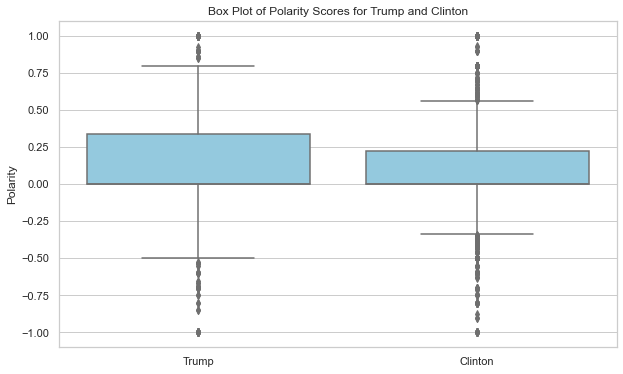

In [148]:
# Calculate polarity on preprocessed_text
trump['polarity'] = trump['preprocessed_text'].apply(lambda text: TextBlob(' '.join(text)).sentiment.polarity)
clinton['polarity'] = clinton['preprocessed_text'].apply(lambda text: TextBlob(' '.join(text)).sentiment.polarity)

# Combine the polarity scores for Trump and Clinton into a single DataFrame
combined_df = pd.concat([trump['polarity'], clinton['polarity']], axis=1)
combined_df.columns = ['Trump', 'Clinton'] 

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the box plot using Seaborn and set the color
sns.boxplot(data=combined_df, color='skyblue')

# Set the title and ylabel
plt.title('Box Plot of Polarity Scores for Trump and Clinton')
plt.ylabel('Polarity')

# Show the plot
plt.show()


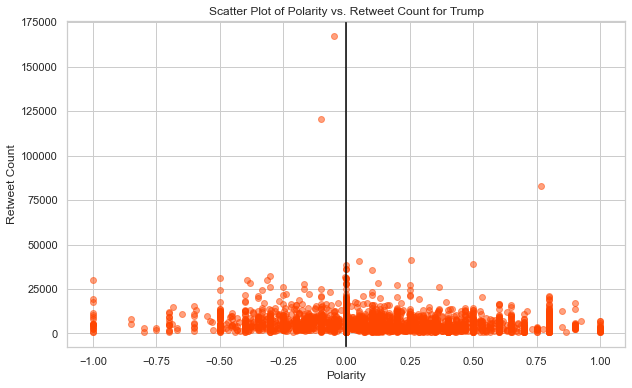

In [149]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the scatter plot
plt.scatter(trump['polarity'], trump['retweet_count'], color='orangered', alpha=0.5)

# Add labels and title
plt.xlabel('Polarity')
plt.ylabel('Retweet Count')
plt.title('Scatter Plot of Polarity vs. Retweet Count for Trump')

# Add a vertical line at polarity = 0
plt.axvline(x=0, color='black')

# Show the plot
plt.show()

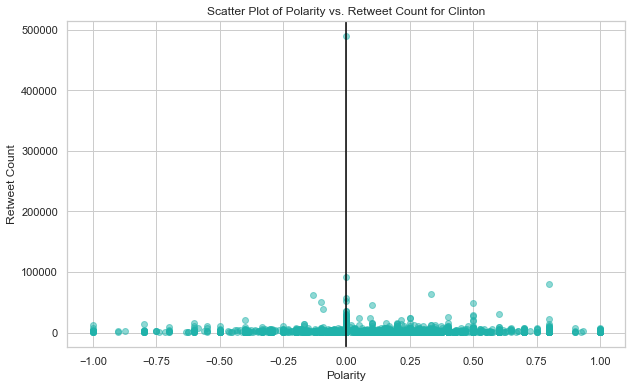

In [150]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the scatter plot
plt.scatter(clinton['polarity'], clinton['retweet_count'], color='lightseagreen', alpha=0.5)

# Add labels and title
plt.xlabel('Polarity')
plt.ylabel('Retweet Count')
plt.title('Scatter Plot of Polarity vs. Retweet Count for Clinton')

# Add a vertical line at polarity = 0
plt.axvline(x=0, color='black')

# Show the plot
plt.show()

### Time-series comparison of ‘favorite’ tweet counts, retweet counts, and sentiment scores for Clinton and Trump 

Favorite count comparison

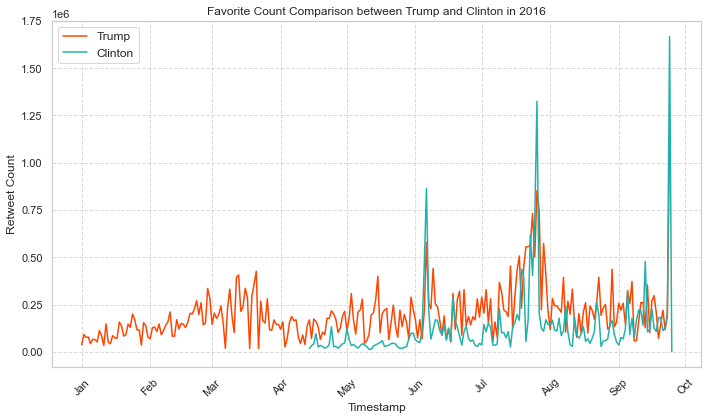

In [151]:
# Group by timestamp and calculate the sum of retweet counts for each group
trump_favorite_count = trump.groupby('date')['favorite_count'].sum().reset_index()
clinton_favorite_count = clinton.groupby('date')['favorite_count'].sum().reset_index()

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(trump_favorite_count.date.to_numpy(), trump_favorite_count.favorite_count.to_numpy(), label='Trump', color='orangered')
plt.plot(clinton_favorite_count.date.to_numpy(), clinton_favorite_count.favorite_count.to_numpy(), label='Clinton', color='lightseagreen')
plt.xlabel('Timestamp')
plt.ylabel('Retweet Count')
plt.title('Favorite Count Comparison between Trump and Clinton in 2016')
plt.legend(loc='upper left', fontsize=12)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Set locator and formatter for x-axis
locator = MonthLocator(range(1, 13), bymonthday=1, interval=1)
formatter = DateFormatter("%b")
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

plt.xticks(rotation=45) 

plt.tight_layout()
plt.show()


Retweet count comparison

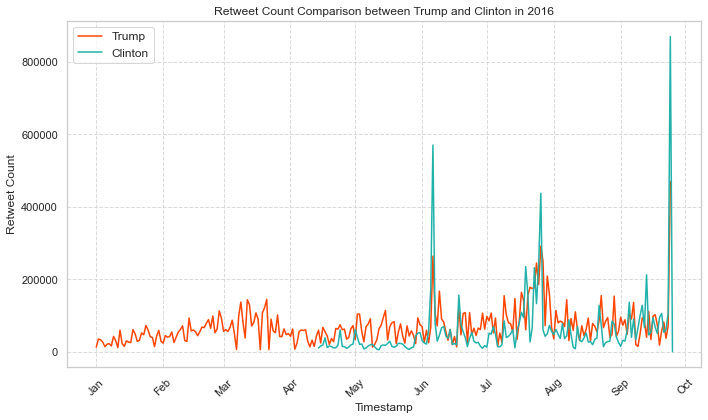

In [152]:
# Group by timestamp and calculate the sum of retweet counts for each group
trump_retweet_counts = trump.groupby('date')['retweet_count'].sum().reset_index()
clinton_retweet_counts = clinton.groupby('date')['retweet_count'].sum().reset_index()

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(trump_retweet_counts.date.to_numpy(), trump_retweet_counts.retweet_count.to_numpy(), label='Trump', color='orangered')
plt.plot(clinton_retweet_counts.date.to_numpy(), clinton_retweet_counts.retweet_count.to_numpy(), label='Clinton', color='lightseagreen')
plt.xlabel('Timestamp')
plt.ylabel('Retweet Count')
plt.title('Retweet Count Comparison between Trump and Clinton in 2016')
plt.legend(loc='upper left', fontsize=12)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Set locator and formatter for x-axis
locator = MonthLocator(range(1, 13), bymonthday=1, interval=1)
formatter = DateFormatter("%b")
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

plt.xticks(rotation=45) 

plt.tight_layout()
plt.show()
